# Cubic Spline vs Exponentially Weighted Average

# Initial code

In [1]:
from datetime import datetime

In [2]:
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import matplotlib.cm as cm
import datasense as ds
import pandas as pd

/usr/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [3]:
c = cm.Paired.colors
date_time_parser = '%Y-%m-%d %H:%M:%S'
date_time_column = 'datetime'
observed_column = 'observed'
predicted_column = 'predicted'
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
figure_width_height = (8, 6)

In [4]:
def read_csv_file(
    filename: str,
    datecolumn: str,
    datetimeparser: str,
) -> pd.DataFrame:
    df = pd.read_csv(
         filename,
         parse_dates=[datecolumn],
         date_parser=lambda s: datetime.strptime(s, datetimeparser)
    )
    return df

In [5]:
def estimate_spline(
    df: pd.DataFrame,
    columnx: str,
    columny: str
) -> CubicSpline:
    '''
    Estimates the spline object for columnx, columny of a dataframe
    Requires that columnx, columny be integer or float
    Removes rows where there are missing values in columnx and columny
    Removes duplicate rows
    Sorts the dataframe by columnx in increasing order
    '''
    df = df.dropna(subset=[columnx, columny])
    df = df.sort_values(by=columnx, axis='rows', ascending=True)
    df = df.drop_duplicates(subset=columnx, keep='first')
    print('final dataframe', df.shape,
          'min', df[columny].min(),
          'max', df[columny].max())
    spline = CubicSpline(df[columnx], df[columny])
    return spline

In [6]:
def plot_graph(
    df: pd.DataFrame,
    columnx: str,
    columny: str,
    columnz: str,
    filename: str,
    graphname: str,
    graphtitle: str,
    graphsubtitle: str,
    yaxislabel: str,
    xaxislabel: str,
    figurewidthheight: str
) -> None:
    fig = plt.figure(figsize=figurewidthheight)
    ax = fig.add_subplot(111)
    ax.plot(
        df[columnx],
        df[columny],
        marker='.',
        linestyle='',
        color=c[1]
    )
    ax.plot(
        df[columnx],
        df[columnz],
        marker=None,
        linestyle='-',
        color=c[5]
    )
    ax.set_title(graphtitle + '\n' + graphsubtitle, )
    ax.set_xlabel(xaxislabel, )
    ax.set_ylabel(yaxislabel, )
    ds.despine(ax=ax)
    file = filename.strip('.csv')
    ax.figure.savefig(f'{graphname}_{file}.png', format='png')

# Cubic Spline

To estimate a spline requies that the dataframe has no missing values, no duplicate rows,  and that the independent variable is sorted in increasing order.

## Example with small dataframe

In [7]:
def cs(
    filename: str,
    datecolumn: str,
    datetimeparser: str,
    observedcolumn: str,
    predictedcolumn: str,
    graphname: str
) -> None:
    df = read_csv_file(filename, datecolumn, datetimeparser)
    print('initial dataframe', df.shape,
          'min', df[observedcolumn].min(),
          'max', df[observedcolumn].max())
    df[datecolumn] = pd.to_numeric(df[datecolumn])
    spline = estimate_spline(df, datecolumn, observedcolumn)
    df[predictedcolumn] = spline(df[datecolumn])
    df[datecolumn] = df[datecolumn].astype('datetime64[ns]')
    plot_graph(
        df,
        datecolumn,
        observedcolumn,
        predictedcolumn,
        filename,
        graphname,
        'Cubic Spline Fit',
        filename,
        observedcolumn,
        datecolumn,
        figure_width_height
    )

initial dataframe (100, 2) min 400.0 max 632.0
final dataframe (95, 2) min 400.0 max 632.0


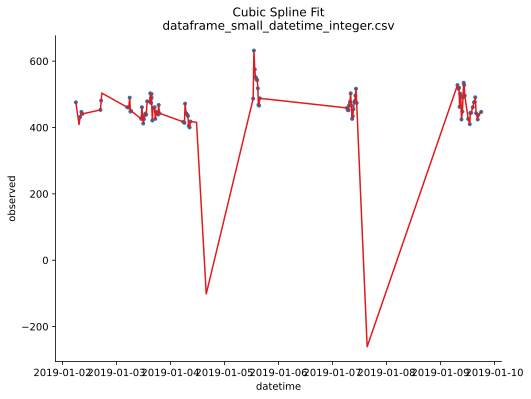

In [8]:
cs(
    'dataframe_small_datetime_integer.csv',
    date_time_column,
    date_time_parser,
    observed_column,
    predicted_column,
    'cubic_spline'
)

## Example with large dataframe

initial dataframe (3326, 2) min 370.0 max 666.0
final dataframe (2952, 2) min 370.0 max 666.0


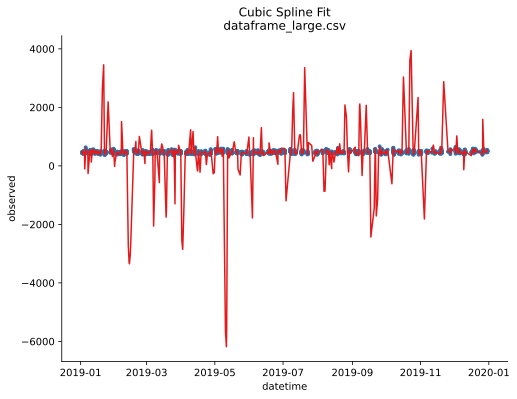

In [9]:
cs(
    'dataframe_large.csv',
    date_time_column,
    date_time_parser,
    observed_column,
    predicted_column,
    'cubic_spline'
)

initial dataframe (2958, 2) min 370 max 666
final dataframe (2952, 2) min 370 max 666


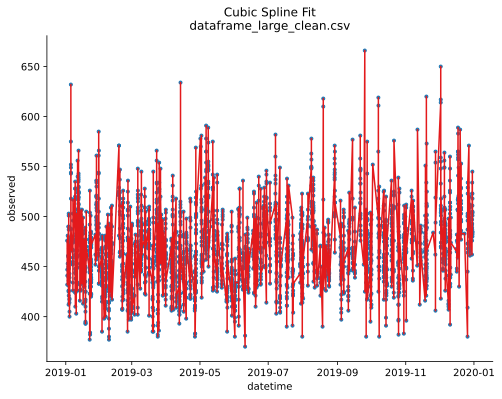

In [10]:
cs(
    'dataframe_large_clean.csv',
    date_time_column,
    date_time_parser,
    observed_column,
    predicted_column,
    'cubic_spline'
)

# Exponentially Weighted Moving Average

Exponentially Weighted Moving Average (EWMA) is also called Exponential Moving Averge (EWA). It is filter that applies weighting factors which decrease exponentially.

## Example with small dataframe

In [11]:
def ewma(
    filename: str,
    datecolumn: str,
    datetimeparser: str,
    observedcolumn: str,
    predictedcolumn: str,
    graphname: str
) -> None:
    df = read_csv_file(filename, datecolumn, datetimeparser)
    print('initial & final', df.shape,
          'min', df[observedcolumn].min(),
          'max', df[observedcolumn].max())
    df[predictedcolumn] = df[observedcolumn].ewm(alpha=1).mean()
    plot_graph(
        df,
        datecolumn,
        observedcolumn,
        predictedcolumn,
        filename,
        graphname,
        'Exponentially Weighted Moving Average Fit',
        filename,
        observedcolumn,
        datecolumn,
        figure_width_height
    )

initial & final (100, 2) min 400.0 max 632.0


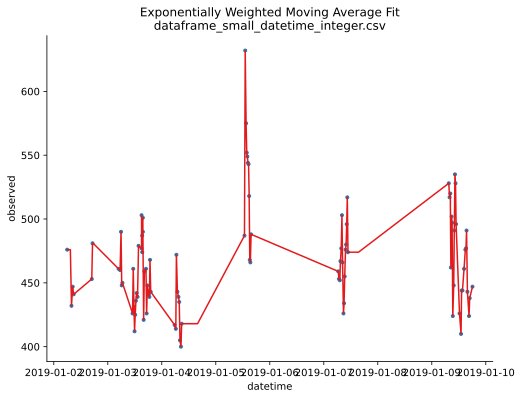

In [12]:
ewma(
    'dataframe_small_datetime_integer.csv',
    date_time_column,
    date_time_parser,
    observed_column,
    predicted_column,
    'ewma'
)

## Example with large dataframe

initial & final (3326, 2) min 370.0 max 666.0


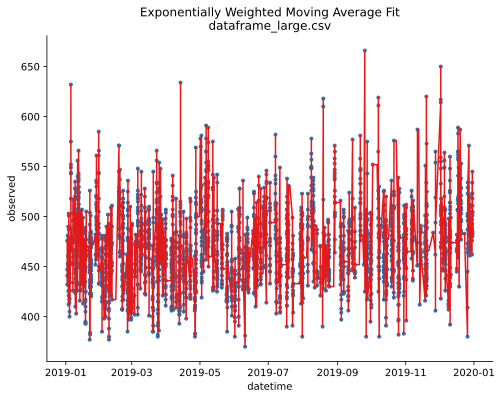

In [13]:
ewma(
    'dataframe_large.csv',
    date_time_column,
    date_time_parser,
    observed_column,
    predicted_column,
    'ewma'
)

initial & final (2958, 2) min 370 max 666


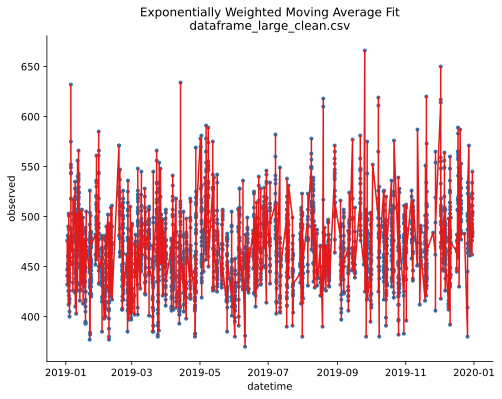

In [14]:
ewma(
    'dataframe_large_clean.csv',
    date_time_column,
    date_time_parser,
    observed_column,
    predicted_column,
    'ewma'
)

# References

[Exponential moving average](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average)

[Exponential smoothin](https://en.wikipedia.org/wiki/Exponential_smoothing)

[Spline interpolation](https://en.wikipedia.org/wiki/Spline_interpolation)